In [1]:
import numpy as np
from scipy.special import softmax
from matplotlib import pyplot as plt
from tqdm import tqdm
from copy import deepcopy
import pandas as pd

## Define Bandit Envirorment and Training

In [2]:
class BernoulliBandit:
    """
    Class that implements a multi armed bandits where the reward of each arm is bernoulli distributed
    """

    def __init__ (self, probs):
        """
        probs: np.array that contains the expected reward for each arm
        """
        self.probs = probs
        self.n_arms = probs.shape[0]
    def pull_arm(self, idx):
        return int(np.random.random() < self.probs[idx])

In [3]:
def get_training_data(bandit, n_steps, learning_rate = 0.01, n_streams=1, cv=0.5):
    n_arms = bandit.n_arms
    reward_history = []
    action_history = []
    Wpolicy_history = []
    dWpolicy_history = []
    for j in range(n_streams):
        Wpolicy = np.ones(n_arms)
        for i in range(n_steps):
            Wpolicy_history.append(np.copy(Wpolicy))
            # choose action sampling from policy
            action = np.random.choice(n_arms, p=softmax(Wpolicy))
            # get reward from bandit 
            reward = bandit.pull_arm(action)
            # update policy
            delta_a = np.arange(n_arms) == action
            dWpolicy = (reward-cv)*(softmax(Wpolicy) - delta_a)
            Wpolicy +=  -learning_rate*dWpolicy
            # save to create dataset 
            reward_history.append(reward)
            dWpolicy_history.append(dWpolicy)
            action_history.append(action)
        

    rewards = np.stack(reward_history)[:, None]
    actions = np.stack(action_history)
    Wpolicies = np.stack(Wpolicy_history)
    dWpolicies = np.stack(dWpolicy_history)
    actions = (np.arange(n_arms)[None,:] == actions[:, None])*1

    return rewards, actions, Wpolicies, dWpolicies

## Test policy gradient

In [4]:
n_arms = 10
p=0.95
probs = (np.arange(n_arms) % 3 == 0)*p + (np.arange(n_arms) % 3 != 0)*(1-p)
probs = (np.arange(n_arms) % 2 == 0)*p + (np.arange(n_arms) % 2 == 1)*(1-p)
bandit = BernoulliBandit(probs)
learning_rate = 0.1
n_steps = 1000
rewards, actions, Wpolicies, dWpolicies = get_training_data(bandit, n_steps, learning_rate = learning_rate)

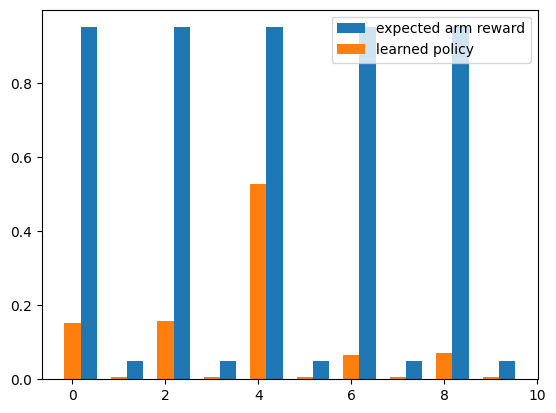

policy gradient score:  0.9245380495792388


In [5]:
bar_width = 0.35
index = np.arange(bandit.n_arms)
fig, ax = plt.subplots()
ax.bar(index+bar_width, bandit.probs,
                 bar_width, label="expected arm reward")
ax.bar(index, softmax(Wpolicies[-1]), bar_width,
                label="learned policy")
ax.legend()
plt.show()
print("policy gradient score: ", np.sum(bandit.probs*softmax(Wpolicies[-1])))
pgscore = np.sum(bandit.probs*softmax(Wpolicies[-1]))

## Define gain modulated ELM architecture

In [6]:
class GMELM:
    
    def __init__ (self, par):
        # This are the network size N, input I, output O and max temporal span T
        self.N, self.I, self.Ia = par['shape'][0], par["shape"][1], par["shape"][2]
        self.par = par
        # This is the network input, teach and output matrices
        Jin1 = np.random.normal(0., par['sigma_Jin']/np.sqrt(self.I), size = (self.I, self.N))
        Jin2 = np.random.normal(0., par['sigma_Jap']/np.sqrt(self.Ia), size = (self.Ia, self.N))
        self.Jin = np.concatenate([Jin1, Jin2])
        self.bin = np.random.normal(0., par['sigma_bin'], size = (self.N)) 

        self.H = np.zeros(self.N)
        
         
        #self.Jap=  np.random.normal(size=(self.Ia, self.N))*par["sigma_Jap"]/np.sqrt(self.Ia)*np.sin(self.par["gamma"]*np.pi/4)
        self.Jap =  Jin2*np.sin(self.par["gamma"]*np.pi/4)
        
        self.bap = np.random.normal(size=(self.N))*par["sigma_bap"]*np.cos(self.par["gamma"]*np.pi/4); 
        # Softplus
        # self.phi = lambda x: np.log(1 + np.exp(x))
        # self.phi = lambda x: x
        self.phi = par["phi"]
        self.Jout = None
        
    def get_features(self, inp, gain): 
        g = (self.bap + (gain)@self.Jap)
        inp = np.concatenate([inp, gain], 1)
        self.H = self.phi(g*(inp@self.Jin + self.bin))
       
        return self.H




    def __call__(self, inp, gain): 
        self.get_features(inp, gain)
        return self.H@self.Jout
        #return self.clf.predict(self.H[None,:])[0]
    
    def train(self, X_in, X_ap, Y, alpha=0):
        
        H = self.get_features(X_in, X_ap)
        n_col = H.shape[1]
        self.Jout = np.linalg.lstsq(H.T.dot(H) + alpha * np.identity(n_col), H.T.dot(Y), rcond=None)[0]
        #self.Jout = np.linalg.pinv(H)@Y

## Train and test functions

In [7]:
def train_pg_bandit(par, rewards, actions, Wpolicies, dWpolicies):
    net = GMELM(par)
    inp = np.concatenate([actions, softmax(Wpolicies, axis=1)], 1)
    gain = rewards - 0.5
    net.train(inp, gain, dWpolicies)
    return net

In [8]:
def test_model(net, bandit, n_steps, learning_rate=0.1):
    
    n_arms = bandit.n_arms
    Wpolicy = np.ones(bandit.n_arms)[None,:]/n_arms
    reward_history_model = []
    Wpolicy_history = []
    policy = softmax(Wpolicy)
    for i in range(n_steps):
        # choose action sampling from policy
        policy = softmax(Wpolicy)
        action = np.random.choice(n_arms, p=policy[0])
        # get reward from bandit 
        reward = np.array(bandit.pull_arm(action))[None,None]
        # update policy
        delta_a = np.arange(n_arms)[None, :] == action
        inp = np.concatenate([delta_a, policy], 1)
        gain = reward - 0.5
        dWpolicy = net(inp, gain)
        Wpolicy +=  -learning_rate*dWpolicy
        # normalize s.t. sum(policy) == 1
        # save to create dataset 
        reward_history_model.append(reward)
    final_score = np.sum(bandit.probs*policy)
    return final_score, reward_history_model

In [9]:
def train_eval(par, trainpar, probs, probs2):
    bandit = BernoulliBandit(probs)
    bandit2 = BernoulliBandit(probs2)
    scores_in = []
    scores_out = []
    for n in range(trainpar['n_trials']):
        rewards, actions, Wpolicies, dWpolicies = get_training_data(bandit, trainpar['n_steps'], 
                                                                        trainpar['learning_rate'], 
                                                                        n_streams = trainpar['n_streams'])
        net =  train_pg_bandit(par, rewards, actions, Wpolicies, dWpolicies)
        
        scores_in.append(deepcopy(test_model(net, bandit, n_steps=trainpar['n_steps_test'], learning_rate=trainpar['learning_rate_test'])[0]))
        scores_out.append(deepcopy(test_model(net, bandit2, n_steps=trainpar['n_steps_test'], learning_rate=trainpar['learning_rate_test'])[0]))
    dout = {}
    dout.update(par)
    dout.update(trainpar)
    dout["in"] = np.array(scores_in)
    dout["out"] = np.array(scores_out)
    return dout

In [10]:
def train_eval_regret(par, trainpar, probs, probs2):
    bandit = BernoulliBandit(probs)
    bandit2 = BernoulliBandit(probs2)
    scores_in = []
    scores_out = []
    rewards, actions, Wpolicies, dWpolicies = get_training_data(bandit, trainpar['n_steps'], 
                                                                        trainpar['learning_rate'], 
                                                                        n_streams = trainpar['n_streams'])
    net =  train_pg_bandit(par, rewards, actions, Wpolicies, dWpolicies)
    for n in range(trainpar['n_trials']):        
        scores_in.append(deepcopy(test_model(net, bandit, n_steps=trainpar['n_steps_test'], learning_rate=trainpar['learning_rate_test'])[1]))
        scores_out.append(deepcopy(test_model(net, bandit2, n_steps=trainpar['n_steps_test'], learning_rate=trainpar['learning_rate_test'])[1]))
    return np.array(scores_in)[:,:,0,0], np.array(scores_out)[:,:,0,0]

In [356]:
### Define the train parameters

trainpar = {
"n_arms": 10,
"n_trials": 20,
"learning_rate": 0.1,
"n_steps": 1000,
"n_steps_test": 100,
"learning_rate_test": 1,
"n_streams": 1,
}

p = 0.95
probs = (np.arange(trainpar['n_arms']) % 2 == 0)*p + (np.arange(trainpar['n_arms']) % 2 == 1)*(1-p)
probs2 = (np.arange(trainpar['n_arms']) % 2 == 1)*p + (np.arange(trainpar['n_arms']) % 2 == 0)*(1-p)

N_range = list(range(10, 110, 10))
results = []
N = 100 
for sigma in tqdm(np.round(10**(np.linspace(-2, 0, 10)), 2)): 
    for phi in [np.tanh, lambda x: np.log(1 + np.exp(x))]:
        for bias in np.arange(0,1.1,0.1):
            for gamma in [0,1]:

                par = {
                'sigma_Jin': sigma,
                "sigma_bin": bias,
                "sigma_bap": sigma,
                "sigma_Jap": sigma,
                'gamma': gamma, 
                "sigma": sigma,
                'phi': phi,   
                "shape": (N, n_arms*2, 1),
                "N": N,
                }


                results.append(train_eval(par, trainpar, probs, probs2))

100%|██████████| 10/10 [22:56<00:00, 137.68s/it]


In [357]:
df_hyper = pd.DataFrame(results)
df_hyper["score_out"] = df_hyper["out"].apply(lambda x: - np.percentile(x, 20))
df_best = df_hyper.sort_values("score_out").drop_duplicates(subset="gamma")
hyperparams = {i: df_best.loc[df_best['gamma'] == i][['phi', 'sigma', 'sigma_bin']].iloc[0].to_dict() for i in [0,1]}
print(hyperparams[0])
print(hyperparams[1])

{'phi': <function <lambda> at 0x7fe0013f97a0>, 'sigma': 0.6, 'sigma_bin': 1.0}
{'phi': <function <lambda> at 0x7fe0014168c0>, 'sigma': 0.01, 'sigma_bin': 0.9}


In [377]:
trainpar['n_trials'] = 100
N_range = list(range(10, 110, 10))
results = []
for N in tqdm(N_range):
    for gamma in [0,1]:
                par = {
                'sigma_Jin': hyperparams[gamma]["sigma"],
                "sigma_bin": hyperparams[gamma]["sigma_bin"],
                "sigma_bap": hyperparams[gamma]["sigma"],
                "sigma_Jap": hyperparams[gamma]["sigma"],
                'phi': hyperparams[gamma]["phi"], 
                "gamma": gamma,
                "shape": (N, n_arms*2, 1),
                "N": N,
                }


                results.append(train_eval(par, trainpar, probs, probs2))
                
# save the results


100%|██████████| 15/15 [07:06<00:00, 28.44s/it]


## Plot results

In [ ]:
df_best = pd.DataFrame(results)

In [379]:
def get_best_params(df):
    bestidx = np.argmax(df['out'].apply(lambda x: np.mean(x)))
    bestrow = df.iloc[bestidx]
    return bestrow 

def get_perc_scores_(df):   
    bestrow = df.iloc[0] 
    return pd.Series({
        'in_low': np.percentile(bestrow['in'], 20.),
        'in_med': np.percentile(bestrow['in'], 50.),
        'in_high': np.percentile(bestrow['in'], 80.),
        'out_low': np.percentile(bestrow['out'], 20.),
        'out_med': np.percentile(bestrow['out'], 50.),
        'out_high': np.percentile(bestrow['out'], 80.),
    })

### Panel C

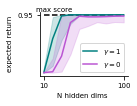

In [405]:
c0 = 'mediumorchid'
c1 = 'teal'
mm = 1/25.4  # mm in inches
fig, ax = plt.subplots(figsize=(40*mm, 30*mm))
ax.set_ylim((0.0,1))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel("N hidden dims ", fontdict={'size': 7})
ax.set_ylabel("expected return", fontdict={'size': 7})

N_range = range(10, 110, 10)
df_perc = df_best.groupby(["N", 'gamma']).apply(get_perc_scores_, include_groups=False)
df0 = df_perc.loc[[(i, 0.0) for i in N_range]]
df1 = df_perc.loc[[(i, 1) for i in N_range]]
plt.fill_between(N_range, df1["out_low"], df1["out_high"], alpha=0.2, color=c1)
plt.fill_between(N_range, df0["out_low"], df0["out_high"], alpha=0.2, color=c0)


plt.text(x=0.9, y=1.0, s= "max score", fontdict={'size': 7})
ax.hlines([0.95], [10], [100], color='black', linestyle="dashed", zorder=-10)
plt.plot(N_range, df1["out_med"], color=c1, label="$\\gamma = 1$")
plt.plot(N_range, df0["out_med"], color=c0, label="$\\gamma = 0$")
ax.tick_params(axis='both', labelsize=7)
ax.legend(loc=4, prop={'size': 7})
ax.set_yticks([0.95])
ax.set_xticks([10, 100])
plt.savefig("bandits_1.pdf", bbox_inches='tight')


### Panel D

In [743]:
scores_out0 = []
scores_out1 = []
dic_test = deepcopy(trainpar)
dic_test['n_trials'] = 100
dic_test['n_steps_test'] = 1000
dic_test['learning_rate_test'] = 1
dic_test['n_steps'] = 1000
dic_test['n_streams'] = 1
dic_test['learning_rate_train'] = 0.1
for i in range(5):
    dic = df_best.loc[(df_best["N"] == 100)&(df_best["gamma"] == 0)].iloc[0].to_dict()
    scores_out0.append(train_eval_regret(dic, dic_test, probs, probs2)[1])
    
    dic = df_best.loc[(df_best["N"] == 100)&(df_best["gamma"] == 1)].iloc[0].to_dict()
    scores_out1.append(train_eval_regret(dic, dic_test, probs, probs2)[1])

scores_pg = [get_training_data(bandit, dic_test['n_steps_test'], dic_test['learning_rate_test'], 1, cv=0.5)[0] for i in tqdm(range(dic_test['n_trials']))]
scores_pg = np.array(scores_pg)[:,:,0]

100%|██████████| 50/50 [00:02<00:00, 18.01it/s]


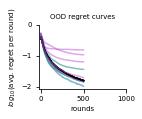

In [744]:
fig, ax = plt.subplots(figsize=(40*mm, 30*mm)) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
bandit = BernoulliBandit(probs)
#avg_reg_in = ((np.arange(dic['n_steps_test'])+1)*0.95 - np.cumsum(scores_in, axis=1))
avg_reg_pg = ((np.arange(dic_test['n_steps_test'])+1)*0.95 - np.cumsum(scores_pg, axis=1))
plt.title("OOD regret curves", fontsize=7)

for r0, r1 in list(zip(scores_out0, scores_out1)):
    avg_reg_pg = ((np.arange(dic_test['n_steps_test'])+1)*0.95 - np.cumsum(scores_pg, axis=1))
    avg_reg_out1 = ((np.arange(dic_test['n_steps_test'])+1)*0.95 - np.cumsum(r1, axis=1))
    avg_reg_out0 = ((np.arange(dic_test['n_steps_test'])+1)*0.95 - np.cumsum(r0, axis=1))
    plt.plot(np.log10(np.mean(avg_reg_out1/(np.arange(dic_test['n_steps_test'])+1), axis=0)), color=c1, alpha=0.5)
    plt.plot(np.log10(np.mean(avg_reg_pg/(np.arange(dic_test['n_steps_test'])+1), axis=0)), color="black")
    plt.plot(np.log10(np.mean(avg_reg_out0/(np.arange(dic_test['n_steps_test'])+1), axis=0)), color=c0, alpha=0.5)
ax.set_yticks([0, -1, -2])
ax.set_xticks([0, 500, 1000])
plt.xlabel('rounds', fontsize=7)
ax.tick_params(axis='both', labelsize=7)
plt.ylabel('$log_{10}$(avg. regret per round)', fontsize=7)
plt.savefig("bandits_2_.pdf", bbox_inches='tight')

### Panel B

In [760]:
reg_out0 = []
reg_out1 = []
reg_in0 = []
reg_in1 = []
reg_pg = []

scores_out0 = []
scores_out1 = []
dic_test = deepcopy(trainpar)
dic_test['n_trials'] = 1
dic_test['n_steps_test'] = 500
dic_test['learning_rate_test'] = 1
dic_test['n_steps'] = 1000
dic_test['learning_rate_train'] = 0.1
for i in tqdm(range(100)):
    dic = df_best.loc[(df_best["N"] == 100)&(df_best["gamma"] == 0)].iloc[0].to_dict()
    rin0, rout0 = train_eval_regret(dic, dic_test, probs, probs2)
    
    dic = df_best.loc[(df_best["N"] == 100)&(df_best["gamma"] == 1)].iloc[0].to_dict()
    rin1, rout1 = train_eval_regret(dic, dic_test, probs, probs2)

    scores_pg = [get_training_data(bandit, dic_test['n_steps_test'], dic_test['learning_rate_test'], 1, cv=0.5)[0] for i in range(dic_test['n_trials'])]
    scores_pg = np.array(scores_pg)[:,:,0]
              
    reg_pg.append(((np.arange(dic_test['n_steps_test'])+1)*0.95 - np.cumsum(scores_pg, axis=1))[0, -1])
    reg_out1.append(((np.arange(dic_test['n_steps_test'])+1)*0.95 - np.cumsum(rout1, axis=1))[0, -1])
    reg_out0.append(((np.arange(dic_test['n_steps_test'])+1)*0.95 - np.cumsum(rout0, axis=1))[0, -1])
    reg_in1.append(((np.arange(dic_test['n_steps_test'])+1)*0.95 - np.cumsum(rin1, axis=1))[0, -1])
    reg_in0.append(((np.arange(dic_test['n_steps_test'])+1)*0.95 - np.cumsum(rin0, axis=1))[0, -1])

reg_pg = np.array(reg_pg)/dic_test['n_steps_test']
reg_in0 = np.array(np.abs(reg_in0))/dic_test['n_steps_test']
reg_out0 = np.array(np.abs(reg_out0))/dic_test['n_steps_test']
reg_in1 = np.array(np.abs(reg_in1))/dic_test['n_steps_test']
reg_out1 = np.array(np.abs(reg_out1))/dic_test['n_steps_test']
# negative values are given smallest possible positive value 1/dic_test['n_steps_test']
reg_pg[reg_pg<=0] = 1/dic_test['n_steps_test']
reg_in0[reg_in0<=0] = 1/dic_test['n_steps_test']
reg_in1[reg_in1<=0] = 1/dic_test['n_steps_test']
reg_out0[reg_out0<=0] = 1/dic_test['n_steps_test']
reg_out1[reg_out1<=0] = 1/dic_test['n_steps_test']

reg_pg = np.log10(reg_pg)
reg_in0 = np.log10(reg_in0)
reg_in1 = np.log10(reg_in1)
reg_out0 = np.log10(reg_out0)
reg_out1 = np.log10(reg_out1)

100%|██████████| 100/100 [00:32<00:00,  3.08it/s]


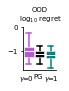

In [767]:
fig, ax = plt.subplots(figsize=(15*mm, 20*mm)) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

bplot = ax.boxplot([reg_out0], positions=[1.1],
                   widths=0.9, patch_artist=True,
                    showmeans=False, showfliers=False,
                    medianprops={"color": "white", "linewidth": 1},
                    boxprops={"facecolor": c0, "edgecolor": "white",
                          "linewidth": 0.5},
                    whiskerprops={"color": c0, "linewidth": 1.5},
                    capprops={"color": c0, "linewidth": 1.5})

bplot = ax.boxplot([reg_pg], positions=[2.1],
                   widths=0.9, patch_artist=True,
                    showmeans=False, showfliers=False,
                    medianprops={"color": "white", "linewidth": 1},
                    boxprops={"facecolor": "black", "edgecolor": "white",
                          "linewidth": 0.5},
                    whiskerprops={"color": "black" , "linewidth": 1.5},
                    capprops={"color": "black" , "linewidth": 1.5})

bplot = ax.boxplot([reg_out1], positions=[3.1],
                   widths=0.9, patch_artist=True,
                    showmeans=False, showfliers=False,
                    medianprops={"color": "white", "linewidth": 1},
                    boxprops={"facecolor": c1, "edgecolor": "white",
                          "linewidth": 0.5},
                    whiskerprops={"color": c1, "linewidth": 1.5},
                    capprops={"color": c1, "linewidth": 1.5})


ax.set_ylim((-1.8 , -0.3))

ax.set_yticks([0, -1])
ax.set_xticks([0.9, 2.0, 3.1])
ax.set_xticklabels(["$\gamma\!\!=\!\!0$", "PG", "$\gamma\!\!=\!\!1$"])
plt.title('OOD\n $\log_{10}$ regret', fontsize=7)
ax.tick_params(axis='x', labelsize=7, length=0)
ax.tick_params(axis='y', labelsize=7, length=2)


plt.savefig("bandits_3.pdf", bbox_inches='tight')
plt.show()

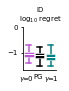

In [770]:
fig, ax = plt.subplots(figsize=(15*mm, 20*mm)) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

bplot = ax.boxplot([reg_in0], positions=[1.1],
                   widths=0.9, patch_artist=True,
                    showmeans=False, showfliers=False,
                    medianprops={"color": "white", "linewidth": 1},
                    boxprops={"facecolor": c0, "edgecolor": "white",
                          "linewidth": 0.5},
                    whiskerprops={"color": c0, "linewidth": 1.5},
                    capprops={"color": c0, "linewidth": 1.5})

bplot = ax.boxplot([reg_pg], positions=[2.1],
                   widths=0.9, patch_artist=True,
                    showmeans=False, showfliers=False,
                    medianprops={"color": "white", "linewidth": 1},
                    boxprops={"facecolor": "black", "edgecolor": "white",
                          "linewidth": 0.5},
                    whiskerprops={"color": "black" , "linewidth": 1.5},
                    capprops={"color": "black" , "linewidth": 1.5})

bplot = ax.boxplot([reg_in1], positions=[3.1],
                   widths=0.9, patch_artist=True,
                    showmeans=False, showfliers=False,
                    medianprops={"color": "white", "linewidth": 1},
                    boxprops={"facecolor": c1, "edgecolor": "white",
                          "linewidth": 0.5},
                    whiskerprops={"color": c1, "linewidth": 1.5},
                    capprops={"color": c1, "linewidth": 1.5})



ax.set_ylim((-1.7, -0.5))

ax.set_yticks([0, -1])
ax.set_xticks([0.9, 2.0, 3.1])
ax.set_xticklabels(["$\gamma\!\!=\!\!0$", "PG", "$\gamma\!\!=\!\!1$"])
plt.title('ID\n $\log_{10}$ regret', fontsize=7)
ax.tick_params(axis='x', labelsize=7, length=0)
ax.tick_params(axis='y', labelsize=7, length=2)

plt.savefig("bandits_4.pdf", bbox_inches='tight')
plt.show()